# Analysis of Relations Game Experiments
This notebook collects and analyses experiment results that are run on the relations game dataset.

In [1]:
# Collect imports
from typing import Dict
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.tracking import MlflowClient

np.set_printoptions(suppress=True, precision=5, linewidth=120)

In [48]:
# Setup mlflow client
mlclient = MlflowClient(tracking_uri="") # Emptry string for local
exp_list = [x.name for x in mlclient.list_experiments()]
print(exp_list)

['20210212-114010', '20210212-115123', '20210212-120313', '20210212-121107']


## Aggregate Experiment Results
We will look at aggregate metric performances of runs in a given experiment.

In [49]:
# Explore experiment and run data
experiment_name = "20200806-104823"
experiment_name = exp_list[-1]
mlexp = mlclient.get_experiment_by_name(experiment_name)
print(mlexp)

<Experiment: artifact_location='file:///homes/nuric/phd/pix2rule/mlruns/3', experiment_id='3', lifecycle_stage='active', name='20210212-121107', tags={}>


In [50]:
# Collect all experiment data
def collect_experiment_data(experiment_name: str) -> pd.DataFrame:
    """Collect all experiment run data into dataframe."""
    exp = mlclient.get_experiment_by_name(experiment_name)
    all_runs = mlclient.search_runs(exp.experiment_id)
    # Process data for each run
    run_pds = list()
    for run in all_runs:
        # run.data contains .metrics and .params both are dictionaries
        run_dict = dict()
        for m in run.data.metrics.keys():
            # The following returns a list of Metric objects
            # which have .key .step .value and .timestamp
            mhist = mlclient.get_metric_history(run.info.run_id, m)
            mhist = sorted(mhist, key=lambda x: x.step)
            # Collect values into the dict
            run_dict[m] = [h.value for h in mhist]
        # Append static params
        run_dict['step'] = range(len(run_dict[next(iter(run.data.metrics.keys()))]))
        run_dict['run_id'] = run.info.run_id
        run_dict.update(run.data.params)
        run_pds.append(pd.DataFrame(data=run_dict))
    return pd.concat(run_pds)

exp_data = collect_experiment_data(experiment_name)
exp_data

,train_loss,train_acc,test_pentos_loss,test_pentos_acc,test_hexos_loss,test_hexos_acc,time,train_relaxed_object_selection/temperature,train_and_layer/temperature,step,...,relsgame_one_hot_labels,data_dir,dataset_name,model_name,experiment_name,max_steps,converged_loss,eval_every,debug,tracking_uri
0,0.577503,0.251419,0.573094,0.250,0.572938,0.246,3.245907,0.500000,2.000000,0,...,True,data,relsgame,relsgame_model,20210212-121107,30000,0.1,200,False,None
1,0.570521,0.250910,0.568589,0.253,0.568480,0.266,1.735497,0.450000,1.979038,1,...,True,data,relsgame,relsgame_model,20210212-121107,30000,0.1,200,False,None
2,0.567196,0.251695,0.566118,0.253,0.566028,0.266,1.744933,0.405000,1.958297,2,...,True,data,relsgame,relsgame_model,20210212-121107,30000,0.1,200,False,None
3,0.565276,0.257600,0.564621,0.253,0.564545,0.266,1.743595,0.364500,1.937772,3,...,True,data,relsgame,relsgame_model,20210212-121107,30000,0.1,200,False,None
4,0.564117,0.255793,0.563735,0.253,0.563625,0.266,1.791709,0.328050,1.917463,4,...,True,data,relsgame,relsgame_model,20210212-121107,30000,0.1,200,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.126464,0.939116,0.141673,0.914,0.162386,0.899,1.790010,0.010138,0.434056,145,...,True,data,relsgame,relsgame_model,20210212-121107,30000,0.1,200,False,None
146,0.124999,0.940548,0.143383,0.914,0.162788,0.898,1.786087,0.010138,0.429507,146,...,True,data,relsgame,relsgame_model,20210212-121107,30000,0.1,200,False,None
147,0.124266,0.940810,0.146320,0.911,0.161431,0.903,1.797057,0.010138,0.425006,147,...,True,data,relsgame,relsgame_model,20210212-121107,30000,0.1,200,False,None
148,0.123796,0.941498,0.141092,0.918,0.165890,0.899,1.781079,0.010138,0.420551,148,...,True,data,relsgame,relsgame_model,20210212-121107,30000,0.1,200,False,None


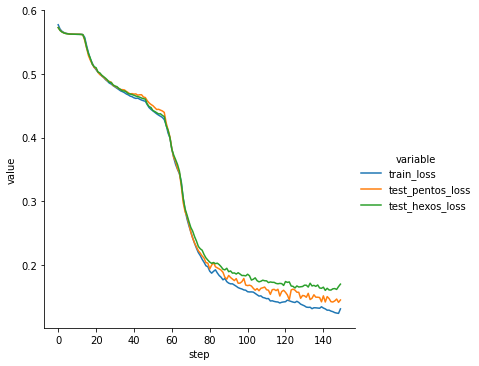

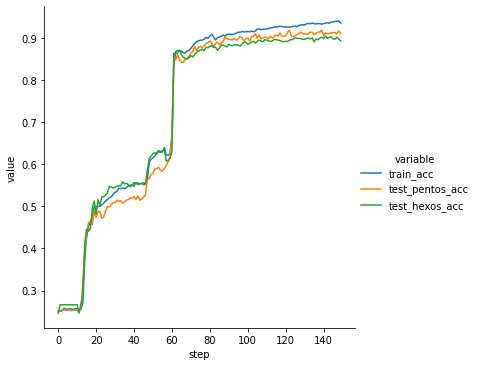

In [51]:
# Plot training and test losses
fields = [k for k in exp_data.columns if k.endswith('loss') and k != "converged_loss"]
plot_data = exp_data.melt(id_vars=['step'], value_vars=fields)
sns.relplot(x='step', y='value', hue='variable', kind='line', data=plot_data)
# Plot training and test accuracy
fields = [k for k in exp_data.columns if k.endswith('acc')]
plot_data = exp_data.melt(id_vars=['step'], value_vars=fields)
sns.relplot(x='step', y='value', hue='variable', kind='line', data=plot_data)

## Analyse Run Report
We can pick a single run and analyse the reports such as attention maps and the rules it has learned.

In [52]:
exp_data.groupby(by="run_id").min()

,train_loss,train_acc,test_pentos_loss,test_pentos_acc,test_hexos_loss,test_hexos_acc,time,train_relaxed_object_selection/temperature,train_and_layer/temperature,step,...,relsgame_one_hot_labels,data_dir,dataset_name,model_name,experiment_name,max_steps,converged_loss,eval_every,debug,tracking_uri
run_id,,,,,,,,,,,,,,,,,,,,,
427c0b70e65140cbac8d0b409fc6cb18,0.123796,0.25091,0.141092,0.249,0.15991,0.246,1.735497,0.010138,0.416144,0,...,True,data,relsgame,relsgame_model,20210212-121107,30000,0.1,200,False,None


In [53]:
# Gather a specific run
run_id = "67e32355b56a481f86d022a71afe39d8"
run_id = exp_data.groupby(by="run_id").min().index[-1]
print("Collecting artifacts for run:", run_id)
mlrun = mlclient.get_run(run_id)
pprint(mlrun.to_dictionary())
pprint(mlclient.list_artifacts(run_id))

{'data': {'metrics': {'test_hexos_acc': 0.8939999938011169,
                      'test_hexos_loss': 0.1697397083044052,
                      'test_pentos_acc': 0.9120000004768372,
                      'test_pentos_loss': 0.14480718970298767,
                      'time': 1.7950754165649414,
                      'train_acc': 0.9364359974861145,
                      'train_and_layer/temperature': 0.41614363,
                      'train_loss': 0.13083656132221222,
                      'train_relaxed_object_selection/temperature': 0.010137769},
          'params': {'converged_loss': '0.1',
                     'data_dir': 'data',
                     'dataset_name': 'relsgame',
                     'debug': 'False',
                     'eval_every': '200',
                     'experiment_name': '20210212-121107',
                     'max_steps': '30000',
                     'model_name': 'relsgame_model',
                     'relsgame_batch_size': '128',
                     'r

In [54]:
def load_report(run_id: str, fpath: str):
    """Load numpy compressed report from given artifact."""
    local_path = mlclient.download_artifacts(run_id, fpath)
    return np.load(local_path)

report = load_report(run_id, "train_report.npz")
print(report.files)

['image', 'task_id', 'label', 'object_scores', 'object_atts', 'objects', 'in_tensor', 'and_kernel', 'or_kernel', 'output']


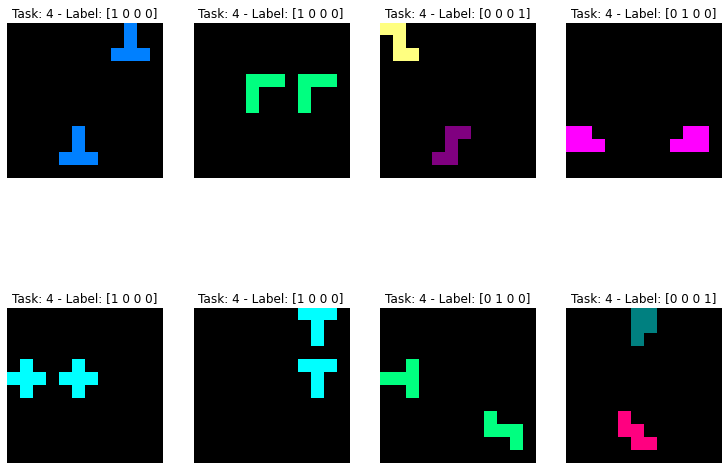

In [55]:
def plot_batch(data: Dict[str, np.ndarray], plot_func, size: int = 8, cols: int = 4, figsize=(12.8, 9.6)):
    """Plot the data in subplots."""
    # data e.g. {'image': (B, ...), 'task_id': (B, ...)}
    plt.figure(figsize=figsize)
    size = size or data[next(iter(data.keys()))].shape[0]
    size = min(size, data[next(iter(data.keys()))].shape[0])
    rows = np.ceil(size / cols).astype(int)
    for i in range(size):
        plt.subplot(rows, cols, i+1)
        plot_func({k: v[i] for k,v in data.items()})
    plt.show()

def plot_image(data: Dict[str, np.ndarray]):
    """Plot single image data point."""
    # data {'image': (W, H, C), 'task_id': (), 'label': ()}
    plt.imshow(data['image'])
    plt.title(f"Task: {data['task_id']} - Label: {data['label']}")
    plt.axis("off")

plot_batch({k: report[k] for k in ['image', 'task_id', 'label']}, plot_image, size=8)

In [56]:
report['object_scores'][0].reshape(5,5)

array([[ -3.80418,  -3.80418,  -3.80418, -32.76986,  21.88593],
       [ -3.80418,  -3.80418,  -3.80418, -15.19303,   5.81225],
       [ -3.80418,  -3.80418,  -3.80418,  -3.80418,  -3.80418],
       [ -3.80418, -11.89389,  -7.48158,  -3.80418,  -3.80418],
       [ -3.80418, -32.76986,  21.88593,   0.70041,  -3.80418]], dtype=float32)

In [57]:
report['object_atts'][0].reshape(2, 5, 5)

array([[[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.]]], dtype=float32)

In [58]:
report['and_kernel'][:2]

array([[[[0.327  , 0.28559, 0.38741],
         [0.30328, 0.36879, 0.32793],
         [0.32539, 0.34869, 0.32593],
         ...,
         [0.37228, 0.30802, 0.3197 ],
         [0.30671, 0.31186, 0.38143],
         [0.34928, 0.36099, 0.28973]],

        [[0.3357 , 0.34862, 0.31568],
         [0.3327 , 0.34246, 0.32485],
         [0.3343 , 0.34793, 0.31777],
         ...,
         [0.31186, 0.38124, 0.3069 ],
         [0.36565, 0.33055, 0.30381],
         [0.32368, 0.30694, 0.36939]],

        [[0.30078, 0.34647, 0.35276],
         [0.3155 , 0.30241, 0.38209],
         [0.32605, 0.32825, 0.3457 ],
         ...,
         [0.34046, 0.37903, 0.28051],
         [0.31472, 0.35485, 0.33043],
         [0.3566 , 0.32685, 0.31656]],

        ...,

        [[0.3293 , 0.35479, 0.31591],
         [0.31669, 0.36446, 0.31885],
         [0.9814 , 0.00913, 0.00947],
         ...,
         [0.30621, 0.35321, 0.34058],
         [0.30847, 0.3542 , 0.33733],
         [0.30731, 0.35108, 0.34161]],

        [[

In [59]:
report['or_kernel']

array([[0.11734, 0.09843, 0.0973 , 0.10505, 0.1011 , 0.00374, 0.00375, 0.99976, 0.09695, 0.10693, 0.09265, 0.10537,
        0.10435, 0.10381, 0.11448, 0.10601, 0.09656, 0.0936 , 0.10469, 0.10773, 0.10245, 0.1018 , 0.09718, 0.09262,
        0.10187, 0.09709, 0.0941 , 0.10046, 0.11069, 0.10083, 0.10548, 0.09785],
       [0.12794, 0.11766, 0.13768, 0.12814, 0.14178, 0.12512, 0.12725, 0.12155, 0.1222 , 0.13047, 0.12274, 0.13429,
        0.11798, 0.12365, 0.1336 , 0.1237 , 0.12549, 0.1328 , 0.12012, 0.00779, 0.12741, 0.13202, 0.11997, 0.99992,
        0.00778, 0.11951, 0.13064, 0.11786, 0.12546, 0.11365, 0.12103, 0.0078 ],
       [0.11146, 0.68797, 0.11158, 0.1144 , 0.1368 , 0.11216, 0.10794, 0.1221 , 0.11185, 0.11245, 0.12016, 0.13179,
        0.11546, 0.13358, 0.09802, 0.11678, 0.1132 , 0.09758, 0.99993, 0.11374, 0.11247, 0.11826, 0.12955, 0.12243,
        0.12664, 0.13123, 0.10725, 0.11072, 0.11226, 0.11854, 0.10923, 0.11706],
       [0.1292 , 0.03307, 0.12059, 0.12325, 0.12831, 0.12158,

In [60]:
report['in_tensor'][:2]

array([[[0.     , 0.     , 0.     , 0.     , 1.     , 0.00002, 1.     , 1.     , 0.     , 0.00002, 1.     , 1.     ,
         0.     , 0.02987, 0.99678, 0.99673, 0.00378, 0.02987, 0.99678, 0.99673, 0.00378],
        [0.     , 0.     , 0.     , 0.     , 1.     , 0.00002, 1.     , 1.     , 0.     , 0.00002, 1.     , 1.     ,
         0.     , 0.02987, 0.99678, 0.99673, 0.00378, 0.02987, 0.99678, 0.99673, 0.00378]],

       [[0.     , 0.     , 0.     , 0.     , 1.     , 0.00001, 1.     , 1.     , 0.     , 0.00001, 1.     , 1.     ,
         0.     , 0.02987, 0.99678, 0.99673, 0.00378, 0.02987, 0.99678, 0.99673, 0.00378],
        [0.     , 0.     , 0.     , 0.     , 1.     , 0.00001, 1.     , 1.     , 0.     , 0.00001, 1.     , 1.     ,
         0.     , 0.02987, 0.99678, 0.99673, 0.00378, 0.02987, 0.99678, 0.99673, 0.00378]]], dtype=float32)